In [50]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import seaborn as sns
import lime
import lime.lime_tabular

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

%matplotlib inline

In [3]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
path = Path('Data/')

In [ ]:
df = pd.read_feather(path/'May2015_subset.fthr')

In [ ]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']

In [ ]:
df = df[df.subreddit.isin(subreddit_list)]

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')

In [ ]:
df['is_flair'] = ~df.author_flair_text.apply(lambda x: x is None)
df['is_flair_css'] = ~df.author_flair_css_class.apply(lambda x: x is None)

Columns with no extra information

In [ ]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col)

In [ ]:
df.drop(['archived', 'id', 'removal_reason',
         'score_hidden', 'downs', 'subreddit_id',
         'author_flair_css_class', 'author_flair_text',
         'author'], axis=1, inplace=True)

In [ ]:
import gc
gc.collect()

In [ ]:
plt.hist(df.score, log=True, bins=300);

In [ ]:
df.subreddit.value_counts()

In [ ]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [ ]:
df.drop(['created_utc'], axis=1, inplace=True)

In [ ]:
df.tail().T

In [ ]:
dfl = pd.read_pickle('Data/scrape/df_final.pkl')

In [ ]:
dfl.shape

Over lapping columns

In [ ]:
[c for c in df.columns if c in dfl.columns]

In [ ]:
for col in dfl.columns:
    if len(dfl[col].unique()) == 1:
        print(col)

This will save some precious RAM when joining the data frame!!

In [ ]:
dfl['url'] = dfl.url.astype('category')
dfl['selftext'] = dfl.selftext.astype('category')
dfl['title'] = dfl.title.astype('category')

In [ ]:
dfl['link_created_time'] = pd.to_datetime(dfl.created_utc, unit='s')

In [ ]:
dfl.drop(['locked', 'downs', 'is_original_content',
          'view_count', 'distinguished', 'edited',
          'num_crossposts', 'spoiler', 'created_utc'], axis=1, inplace=True)

In [ ]:
dfl.rename(columns={'sub_id':'link_id', 
                    'ups': 'link_ups',
                    'score': 'link_score'}, inplace=True)

In [ ]:
dfl.tail().T

In [ ]:
df = df.merge(dfl, on='link_id', how='left')
# for some reason the join doesn't work
# df = df.join(other=dfl, on='link_id', how='outer')

In [ ]:
df.shape

In [ ]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

In [ ]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

In [ ]:
df['time_since_link'] = df.time - df.link_created_time

In [ ]:
df.time_since_link = df.time_since_link.apply(lambda x: x.total_seconds())

In [ ]:
comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)

Just keeping the domain

In [ ]:
df['url'] = df.url.astype('str').apply(lambda x: urlparse(x)[1])
dfl['url'] = dfl.url.astype('category')

In [ ]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [ ]:
regex = re.compile('[^a-zA-Z]')

In [ ]:
df['linked_sr'] = df.linked_sr.apply(lambda x: [regex.sub('', i).lower() for i in x])

In [ ]:
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_domains(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url)[1] for url in urls]
    except:
        return []
    return domain_names

def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)


df['linked_urls'] = df.body.apply(lambda x: get_domains(x))
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [ ]:
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [ ]:
top_url_links = []

for sub in df.subreddit.unique():
    all_linked_urls = []
    for l in df[df.subreddit == sub].linked_urls.values:
        all_linked_urls += l

    top_url_links += Counter(all_linked_urls).most_common(5)

allowed_urls = list(set([i[0] for i in top_url_links]))

In [ ]:
top_sr_links = []

for sub in df.subreddit.unique():
    all_linked_sr = []
    for l in df[df.subreddit == sub].linked_sr.values:
        all_linked_sr += l

    top_sr_links += Counter(all_linked_sr).most_common(5)

allowed_sr = list(set([i[0] for i in top_sr_links]))

In [ ]:
def remove_sr(x):
    y = []
    for i in x:
        if i in allowed_sr:
            y += [i]
    return y

def remove_urls(x):
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

df['a_linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))
df['a_linked_sr'] = df['linked_sr'].apply(lambda x: remove_sr(x))

In [ ]:
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

def get_score(x):
    try:
        return comment_to_score[x]
    except:
        return np.nan

df['parent_score'] = df.parent_id.apply(lambda x: get_score(x))
imp_val = df.parent_score.median()
df.parent_score.fillna(imp_val, inplace=True)

In [ ]:
def get_comment_tree_root(x):
    if comment_to_parent_dict[x][:3] == 't3_':
        return x
    try:
        return get_comment_tree_root(comment_to_parent_dict[x])
    except KeyError:
        return np.nan

In [ ]:
df['comment_tree_root_id'] = df.name.apply(get_comment_tree_root)

In [ ]:
df['comment_tree_root_score'] = df.comment_tree_root_id.apply(lambda x: get_score(x))

In [ ]:
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time(x):
    try:
        return comment_to_time[x]
    except:
        return np.nan

In [ ]:
df['time_since_comment_tree_root'] = df.time - df.comment_tree_root_id.apply(get_time)

In [ ]:
df.time_since_comment_tree_root = df.time_since_comment_tree_root.apply(lambda x: x.total_seconds())

In [ ]:
df['subjectivity'] = df['body'].str.count('I ')

In [ ]:
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def get_sentiment(x):
    return analyser.polarity_scores(x)

In [ ]:
from multiprocessing import Pool

num_partitions = 100
num_cores = 6

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)

df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])

del sentiment

In [ ]:
gc.collect()

In [ ]:
df['is_quoted'] = df.body.str.contains('&gt;')
df['no_quoted'] = df.body.str.count('&gt;')
df['time_since_parent'] = df.parent_id.apply(get_time)
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
df.time_since_parent = df.time - df.time_since_parent
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [ ]:
df['is_root'] = df.parent_id.str.startswith('t3_')

In [ ]:
df['is_selftext'] = df.selftext.str.len() > 1

In [ ]:
df.shape

In [ ]:
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count

del word_counts

In [ ]:
df['epoch_time'] = df.time.astype(np.int64) // 10**9

In [11]:
import gc
gc.collect()

17

In [ ]:
# df.to_pickle('Temp1.pkl')
df = pd.read_pickle('Temp1.pkl')

In [ ]:
def get_past_stats_dict(lid):
    dfs = df[df.link_id == lid][['time', 'score', 'name']]
    dfs = dfs.sort_values(by='time', ascending=True).reset_index(drop=True)
    dfs.reset_index(inplace=True)
    t_dict = pd.DataFrame(data=dfs[['index', 'score']].values,
                        index=dfs['name'].values,
                        columns=['no_of_comments', 'score']).to_dict('index')
    return t_dict

In [ ]:
pool = Pool(num_cores)
list_dicts = pool.map(get_past_stats_dict, df.link_id.unique())

In [ ]:
len(list_dicts)

In [ ]:
df.link_id.unique().shape

In [ ]:
from collections import ChainMap
# y = dict(ChainMap(*list_dicts))

In [ ]:
y = pd.concat([pd.DataFrame.from_dict(d, orient='index') for d in list_dicts])

In [ ]:
y.shape

In [ ]:
y = y.to_dict('index')

In [ ]:
y['t1_cr0uefd']['no_of_comments']

In [ ]:
df['no_of_past_comments'] = df.name.apply(lambda x: y[x]['no_of_comments'])

In [ ]:
df['score_till_now'] = df.name.apply(lambda x: y[x]['score'])

Using Pandas `.query` method for high performance subsetting.
check [this out](https://jakevdp.github.io/PythonDataScienceHandbook/03.12-performance-eval-and-query.html)

In [ ]:
# dfc = df[['link_id', 'time']].copy(deep=True)

In [ ]:
# dfc.set_index(['link_id', 'time'], inplace=True)

In [ ]:
# def get_past_stats(x):
#     lid, t = x.split('|')
#     # return dfc.query(f"link_id == '{lid}' and time < '{t}'").shape[0]
#     no_of_cmnts = temp.shape[0]
#     score = temp['score'].sum()
#     p = temp.query('score >= 0')['score'].sum()
#     n = abs(temp.query('score < 0')['score'].sum())
#     if not (p == 0 and n == 0):
#         up_ratio = p / (p + n)
#     else:
#         up_ratio = 1
#     return no_of_cmnts, score, up_ratio

In [ ]:
#dft = pd.DataFrame(df.link_id + '|' + df.time.map(str), columns=['temp_id'])

In [ ]:
# def wrapper_past_stats(df):
#     df['pat_stats'] = df['temp_id'].apply(get_past_stats)
#     return df

In [ ]:
# parallelize_dataframe(dft, wrapper_past_stats)

In [ ]:
gc.collect()

In [ ]:
# df.to_pickle('Data/Temp4.pkl')
df = pd.read_pickle('Data/Temp4.pkl')

In [ ]:
df.tail().T

In [ ]:
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [ ]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

def get_doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)

    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

gloves = load_glove('Data/glove.twitter.27B.200d.txt')

In [ ]:
from scipy.spatial.distance import cosine, euclidean

In [ ]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')

def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = get_doc2vec(child, gloves)
    parent = get_doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent), euclidean(child, parent)

def wrapper_get_cosine(df):
    df['cosine_euc'] = df['name'].apply(get_cosine_angle)
    return df

cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

df['cosine_euc'] = cosine_angle.cosine_euc

del cosine_angle

In [ ]:
df['parent_cosine'] = df.cosine_euc.apply(lambda x: x[0] if x is not None else None)
df['parent_euc'] = df.cosine_euc.apply(lambda x: x[1] if x is not None else None)

In [ ]:
df.drop(['cosine_euc'], inplace=True, axis=1)

In [ ]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_title = pd_to_dict(df[['name', 'title']],
                                index='name', column='title')

In [ ]:
def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_title[cmnt_id]
        child = get_doc2vec(child, gloves)
        parent = get_doc2vec(parent, gloves)
    except:
        return None
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent), euclidean(child, parent)

def wrapper_get_cosine(df):
    df['cosine_euc'] = df['name'].apply(get_cosine_angle)
    return df

In [ ]:
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)
df['cosine_euc'] = cosine_angle.cosine_euc
del cosine_angle

In [ ]:
df['title_cosine'] = df.cosine_euc.apply(lambda x: x[0] if x is not None else None)
df['title_euc'] = df.cosine_euc.apply(lambda x: x[1] if x is not None else None)

In [ ]:
# del comment_to_body
# del comment_to_parent
# del comment_to_score
# del comment_to_time
# del comment_to_title
# del glovesd

In [ ]:
df.shape

In [ ]:
df.to_pickle('Data/new_data.pkl')
# df = pd.read_pickle('Data/new_data.pkl')

Cleaning

In [ ]:
df.columns

In [ ]:
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)
df['distinguished'] = df.distinguished.astype('category')

In [ ]:
df['no_of_quoted_users'] = df.body.str.count('/u/')

In [ ]:
df['hour_of_comment'] = df.time.apply(lambda x: x.hour)

In [ ]:
df['weekday'] = df.time.dt.weekday

In [ ]:
top_turls_links = []

for sub in df.subreddit.unique():
    top_turls_links += Counter(df[df.subreddit == sub].url.values).most_common(15)

allowed_turls = list(set([i[0] for i in top_turls_links]))

In [ ]:
allowed_turls

In [ ]:
df['title_url_in_top'] = df.url.apply(lambda x: x in allowed_turls)

In [ ]:
df = df[~df.depth.isna()]

In [ ]:
df.loc[df.is_root, 'parent_cosine'] = 1

In [ ]:
df.parent_euc.fillna(df.parent_euc.mean(), inplace=True)

In [ ]:
df.word_counts.quantile(0.995)

In [ ]:
df = df[df['word_counts'] < 280]

In [ ]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df = df[~df.title_cosine.isna()]
df = df[~df.title_euc.isna()]

In [ ]:
df = df[~df.parent_cosine.isna()]

In [ ]:
df.shape

In [ ]:
import seaborn as sns

In [ ]:
sns.countplot(data=df, x='subreddit')

In [ ]:
df.drop(['parent_cos_angle'], inplace=True, axis=1)

In [ ]:
df.reset_index(inplace=True, drop=True)

In [ ]:
df.isna().sum()

In [ ]:
df.columns

In [ ]:
df.url.unique()

In [ ]:
df..unique()

In [14]:
cat_cols = ['subreddit', 'distinguished', 'is_flair', 'is_flair_css']
bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_selftext',
             'title_url_in_top']

# multi_label = a_linked_sr, a_linked_urls
# 'num_comments', 'link_score',  'link_ups', 

numeric_cols = ['gilded', 'controversiality', 'upvote_ratio','time_since_link',
                'depth', 'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'no_of_past_comments', 'parent_cosine',
                'parent_euc', 'title_cosine', 'title_euc', 'no_of_quoted_users',
                'hour_of_comment', 'weekday','link_score']

In [5]:
df = pd.read_pickle('Data/Finale.pkl')
# df.to_pickle('Data/Finale.pkl')

In [6]:
df = df.loc[df.is_root == False]

In [ ]:
del gloves

In [7]:
from scipy.sparse import hstack

In [8]:
lb = LabelBinarizer()

In [15]:
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat

In [16]:
y = df.score.values
x = np.column_stack(tuple(final))

In [17]:
df.shape

(835249, 60)

In [18]:
x.shape

(835249, 42)

In [19]:
gc.collect()

15

## Models

First, we'll make a test-train split that we'll use for all our data:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=10)

In [ ]:
del x, y

In [93]:
def model_diagnostics(model):
    y_predicted = model.predict(X_test)
    r2 = r2_score(y_test, y_predicted)
    mse = mean_squared_error(y_test, y_predicted)
    mae = mean_absolute_error(y_test, y_predicted)
    print(f"R-Sq: {r2:.4}")
    print(f"RMSE: {np.sqrt(mse)}")
    print(f"MAE: {mae}")
    
    return [r2,np.sqrt(mse),mae]

In [22]:
def plot_residuals(y_test, y_predicted):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)

    sns.distplot(y_test, ax=ax0)
    ax0.set(xlabel='Test scores')

    sns.distplot(y_predicted, ax=ax1)
    ax1.set(xlabel="Predicted scores")

    plt.show()
    
    fig, ax2 = plt.subplots()
    
    sns.distplot((y_test-y_predicted), ax = ax2)
    ax2.set(xlabel="Residuals")
    plt.show()

In [23]:
def residuals_histogram(y_test, y_predicted):
    fig, ax = plt.subplots()
    ax.hist(abs(y_test - y_predicted), bins=400, range=[0, 500], log=True)
    ax.set_xlabel("Count")
    ax.set_ylabel("Residuals")
    plt.show()

In [24]:
def y_test_vs_y_predicted(y_test,y_predicted):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted)
    ax.set_xlabel("Test Scores")
    ax.set_ylabel("Predicted Scores")
    plt.show()

In [25]:
def plot_coordinate_descent(model):
    m_log_alphas = -np.log10(model.alphas_)

    fig, ax = plt.subplots(figsize = (20,10))
    
    ax.plot(m_log_alphas, np.sqrt(model.mse_path_), ':')
    ax.plot(m_log_alphas, np.sqrt(model.mse_path_.mean(axis=-1)), 'k',
         label='Average across the folds', linewidth=2)
    ax.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

    ax.legend()

    ax.set_xlabel('-log(alpha)')
    ax.set_ylabel('Root mean square error')
    ax.set_title('Root mean square error on each fold: coordinate descent')
    ax.axis('tight')
    plt.show()

In [26]:
def get_feature_importance(model):
    X_non_text = pd.get_dummies(df[cat_cols])
    features = numeric_cols + bool_cols + list(X_non_text.columns)

    feature_importance = dict(zip(features, model.feature_importances_))
    for name, importance in sorted(feature_importance.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:<30}: {importance:>6.2%}")
  
    print(f"\nTotal importance: {sum(feature_importance.values()):.2%}")
    return feature_importance

In [66]:
def explainer(model):
    X_non_text = pd.get_dummies(df[cat_cols])
    features = numeric_cols + bool_cols + list(X_non_text.columns)

    categorical_features = np.arange(len(numeric_cols)+len(bool_cols),len(features))

    explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features, class_names=['score'],
                                                   categorical_features=categorical_features,
                                                   verbose=True, mode='regression')

    i = 25
    exp = explainer.explain_instance(X_test[i], model.predict, num_features=5)
    return exp

In [27]:
model_performance_dict = dict()

### Dummy Regression

In [74]:
from sklearn.dummy import DummyRegressor

In [90]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train,y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [94]:
model_performance_dict["Baseline"] = model_diagnostics(baseline)

R-Sq: -3.972e-06
RMSE: 49.52894324784488
MAE: 11.380675441478608


### Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [29]:
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('reg', LinearRegression())])

pipe_lr.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [95]:
model_performance_dict["Linear Regression"] = model_diagnostics(pipe_lr)

R-Sq: 0.07123
RMSE: 47.732175851148234
MAE: 11.964798098027813


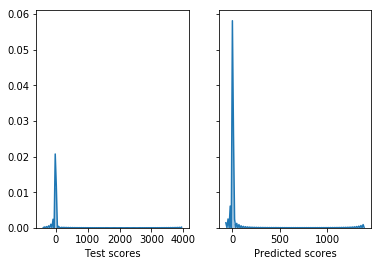

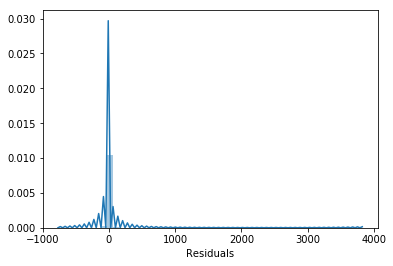

In [31]:
y_predicted = pipe_lr.predict(X_test)
plot_residuals(y_test,y_predicted)

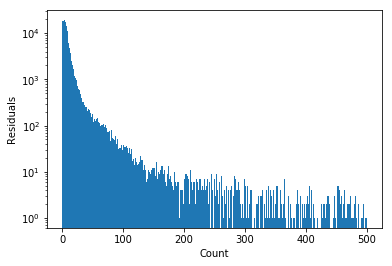

In [32]:
residuals_histogram(y_test,y_predicted)

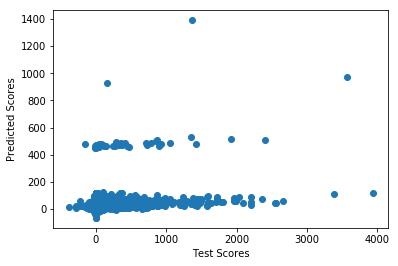

In [33]:
y_test_vs_y_predicted(y_test,y_predicted)

### Lasso Regression

In [34]:
from sklearn.linear_model import LassoCV

In [35]:
lasso = LassoCV(cv=30).fit(X_train, y_train)
lasso.alpha_

169.20362692913852

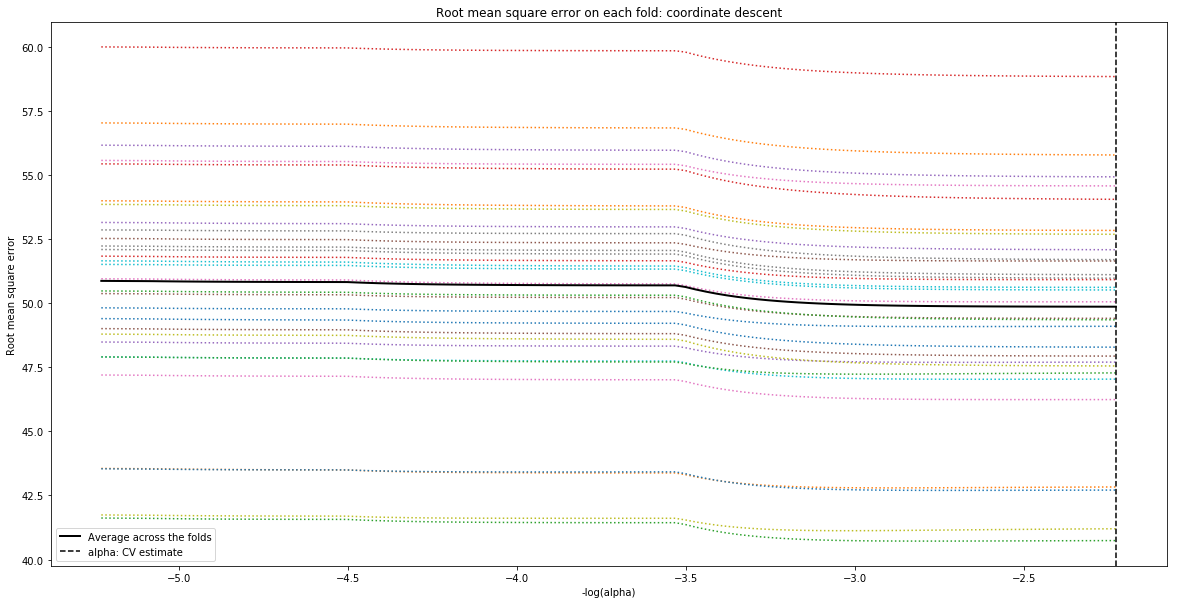

In [36]:
plot_coordinate_descent(lasso)

In [96]:
model_performance_dict["Lasso Regression"] = model_diagnostics(lasso)

R-Sq: 0.03973
RMSE: 48.534881743522526
MAE: 11.65703096475598


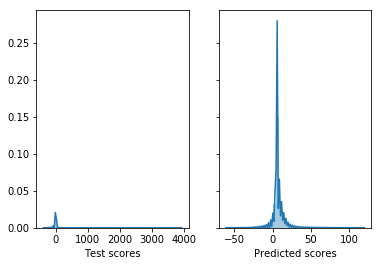

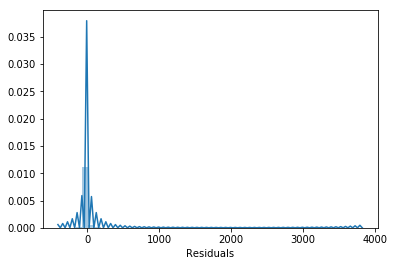

In [38]:
y_predicted = lasso.predict(X_test)
plot_residuals(y_test,y_predicted)

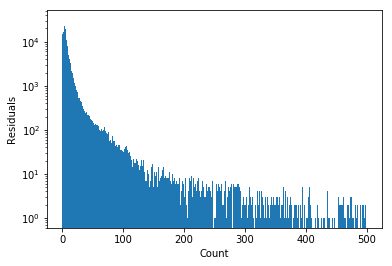

In [39]:
residuals_histogram(y_test,y_predicted)

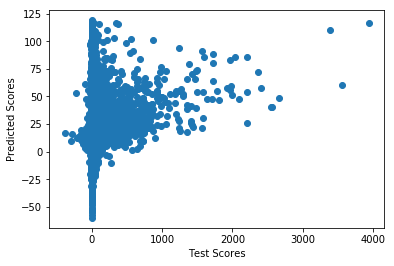

In [40]:
y_test_vs_y_predicted(y_test,y_predicted)

### Ridge Regression

In [ ]:
from sklearn.linear_model import RidgeCV

In [ ]:
ridge = RidgeCV(cv=10).fit(X_train, y_train)
ridge.alpha_

In [ ]:
model_performance_dict["Ridge Regression"] = model_diagnostics(ridge)

In [ ]:
y_predicted = ridge.predict(X_test)
plot_residuals(y_test,y_predicted)

In [ ]:
residuals_histogram(y_test,y_predicted)

In [ ]:
y_test_vs_y_predicted(y_test,y_predicted)

### Elastic Net Regression

In [97]:
from sklearn.linear_model import ElasticNetCV

In [98]:
elastic_net = ElasticNetCV(cv = 30).fit(X_train, y_train)

In [99]:
elastic_net.alpha_

338.4072538582771

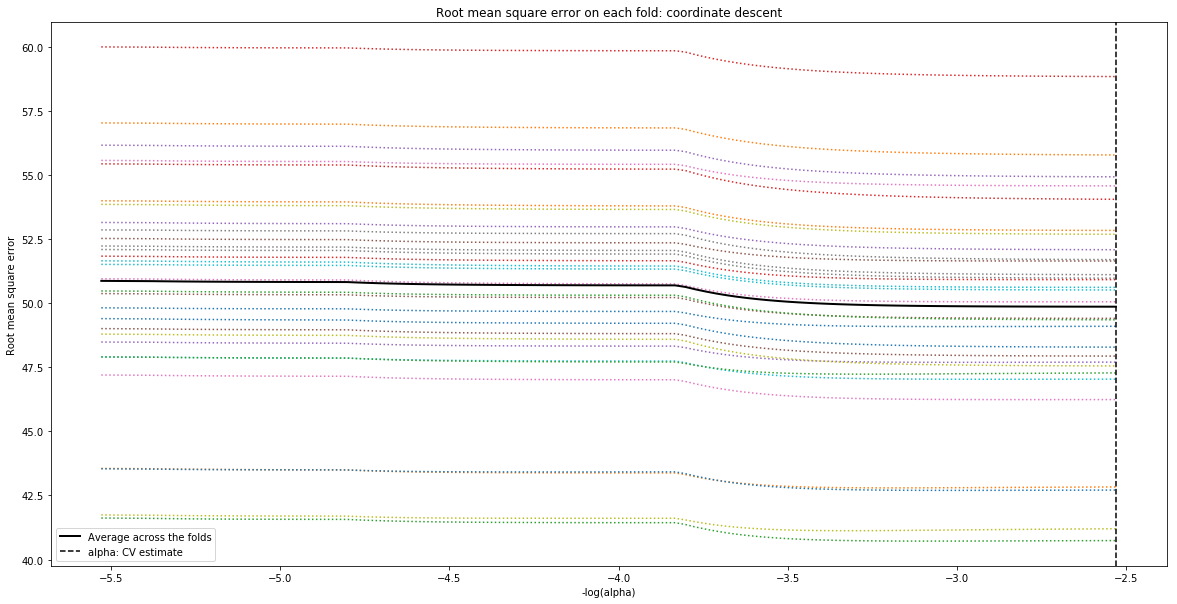

In [100]:
plot_coordinate_descent(elastic_net)

In [101]:
model_performance_dict["Elastic Net Regression"] = model_diagnostics(elastic_net)

R-Sq: 0.03973
RMSE: 48.53490438428505
MAE: 11.656675597185762


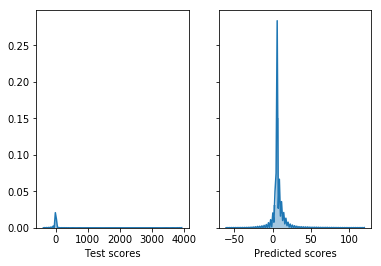

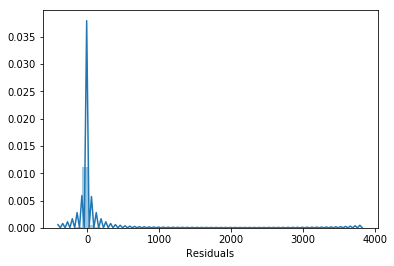

In [102]:
y_predicted = elastic_net.predict(X_test)
plot_residuals(y_test,y_predicted)

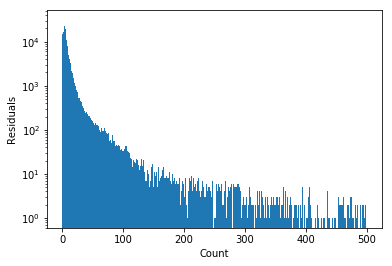

In [103]:
residuals_histogram(y_test,y_predicted)

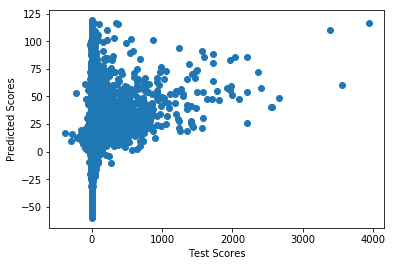

In [104]:
y_test_vs_y_predicted(y_test,y_predicted)

### Decision Tree Regression

In [41]:
from sklearn.tree import DecisionTreeRegressor

In [43]:
dt = DecisionTreeRegressor(min_samples_split=10, min_samples_leaf=10, random_state = 10)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           presort=False, random_state=10, splitter='best')

In [105]:
model_performance_dict["Decision Tree"] = model_diagnostics(dt)

R-Sq: 0.1069
RMSE: 46.80687957741446
MAE: 9.311554249582434


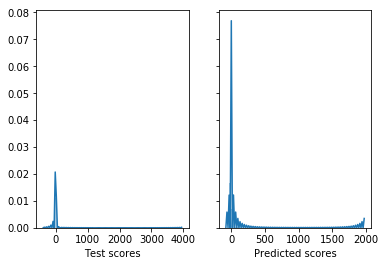

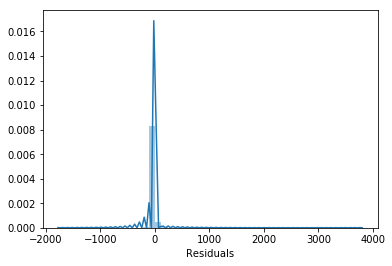

In [45]:
y_predicted = dt.predict(X_test)
plot_residuals(y_test,y_predicted)

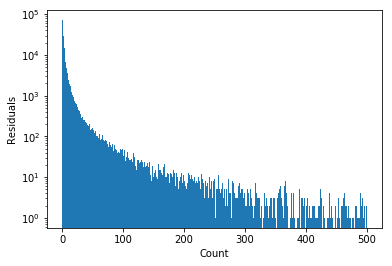

In [46]:
residuals_histogram(y_test,y_predicted)

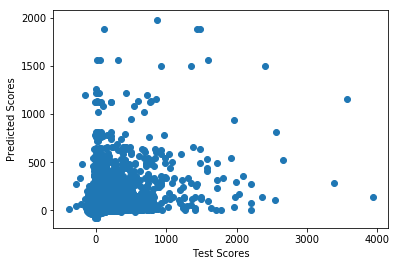

In [47]:
y_test_vs_y_predicted(y_test,y_predicted)

In [49]:
dt_feature_imps = get_feature_importance(dt)

parent_score                  : 23.59%
time_since_parent             : 18.91%
no_of_past_comments           : 11.00%
gilded                        :  8.23%
comment_tree_root_score       :  5.09%
title_cosine                  :  3.86%
link_score                    :  3.70%
title_euc                     :  2.99%
time_since_comment_tree_root  :  2.77%
controversiality              :  2.57%
time_since_link               :  2.02%
senti_pos                     :  2.02%
parent_euc                    :  1.83%
senti_comp                    :  1.82%
hour_of_comment               :  1.56%
upvote_ratio                  :  1.37%
word_counts                   :  1.30%
weekday                       :  1.07%
parent_cosine                 :  1.00%
senti_neg                     :  1.00%
senti_neu                     :  0.71%
is_flair_css                  :  0.42%
subreddit_food                :  0.23%
depth                         :  0.18%
is_selftext                   :  0.16%
is_edited                

In [64]:
exp = explainer(dt)
exp.show_in_notebook(show_table=True)

Intercept -17.10521401307851
Prediction_local [33.5103013]
Right: 0.0


In [65]:
exp.as_list()

[('parent_score <= 1.00', -29.452582876673432),
 ('time_since_parent <= 1149.00', 21.08836833969471),
 ('no_of_quoted_users <= 0.00', 17.924471202654868),
 ('controversiality <= 0.00', 13.39452892937667),
 ('comment_tree_root_score > 683.00', 11.631880533877668),
 ('distinguished_moderator=0', 11.14987228520049),
 ('title_euc <= 2.81', 4.878976900687104),
 ('distinguished_admin=1', 0.0),
 ('subreddit_worldnews=0', 0.0),
 ('subreddit_science=0', 0.0)]

### Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=10, random_state = 10)
rf.fit(X_train, y_train)

In [ ]:
model_performance_dict["Random Forest"] = model_diagnostics(rf)

In [ ]:
y_predicted = rf.predict(X_test)
plot_residuals(y_test,y_predicted)

In [ ]:
residuals_histogram(y_test,y_predicted)

In [ ]:
y_test_vs_y_predicted(y_test,y_predicted)

In [ ]:
rf_feature_imps = get_feature_importance(rf)

In [60]:
exp = explainer(rf)
exp.show_in_notebook(show_table=True)

In [ ]:
exp.as_list()

### Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=60, max_depth=15)
gbr.fit(X_train, y_train)

In [ ]:
model_performance_dict["Gradient Boosting Regression"] = model_diagnostics(gbr)

In [ ]:
y_predicted = gbr.predict(X_test)
plot_residuals(y_test,y_predicted)

In [ ]:
residuals_histogram(y_test,y_predicted)

In [ ]:
y_test_vs_y_predicted(y_test,y_predicted)

### XGBoost Regressor

In [ ]:
import xgboost

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=80, max_depth=15)
xgb.fit(X_train, y_train)

In [ ]:
model_performance_dict["XG Boosted Regression"] = model_diagnostics(xgb)

In [ ]:
y_predicted = xgb.predict(X_test)
plot_residuals(y_test,y_predicted)

In [ ]:
residuals_histogram(y_test,y_predicted)

In [ ]:
y_test_vs_y_predicted(y_test,y_predicted)

### KNN Regressor

In [67]:
from sklearn.neighbors import KNeighborsRegressor

In [68]:
knr = KNeighborsRegressor()
knr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

In [106]:
model_performance_dict["KNN Regression"] = model_diagnostics(knr)

R-Sq: 0.1159
RMSE: 46.57036182657899
MAE: 9.894163424124514


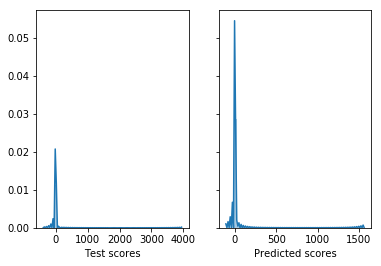

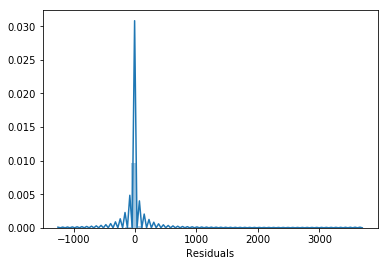

In [70]:
y_predicted = knr.predict(X_test)
plot_residuals(y_test,y_predicted)

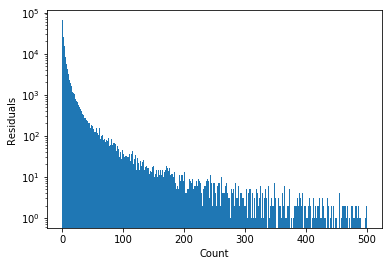

In [71]:
residuals_histogram(y_test,y_predicted)

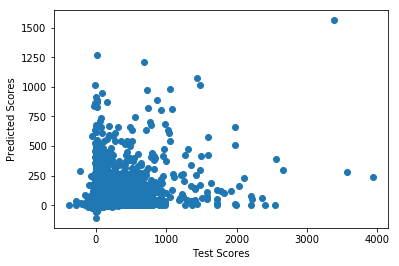

In [72]:
y_test_vs_y_predicted(y_test,y_predicted)

### SVM Regressor

In [ ]:
from sklearn.svm import SVR

In [ ]:
svr = SVR(kernel='rbf', C=0.1, gamma='scale', njobs = -1)
svr.fit(X_train, y_train)

In [ ]:
model_performance_dict["SVM Regression"] = model_diagnostics(svr)

In [ ]:
y_predicted = svr.predict(X_test)
plot_residuals(y_test,y_predicted)

In [ ]:
residuals_histogram(y_test,y_predicted)

In [ ]:
y_test_vs_y_predicted(y_test,y_predicted)

### Bayesian Linear Regression

In [ ]:
#import pymc3 as pm
#formula = ('score ~ ')


In [ ]:
# # Context for the model
# with pm.Model() as normal_model:
    
#     # The prior for the data likelihood is a Normal Distribution
#     family = pm.glm.families.Normal()
    
#     # Creating the model requires a formula and data (and optionally a family)
#     pm.GLM.from_formula(formula, data = X_train, family = family)
    
#     # Perform Markov Chain Monte Carlo sampling letting PyMC3 choose the algorithm
#     normal_trace = pm.sample(draws=2000, chains = 2, tune = 500, njobs=-1)

In [ ]:
#pm.traceplot(normal_trace)

In [ ]:
#pm.plot_posterior(normal_trace)

In [ ]:
#pm.df_summary(normal_trace)

## Parameter Tuning

In [ ]:
# from parfit import bestFit
# from sklearn.model_selection import ParameterGrid

In [ ]:
# params = {
#     "n_estimators": [5,7,10,100],
#     "min_samples_leaf": range(1,5)
# }

In [ ]:
# best_model, best_score, all_models, all_scores = bestFit(RandomForestRegressor(), ParameterGrid(params), 
#                                                          X, y,
#                                                          metric=r2_score, scoreLabel="R-squared")

## Model Comparison

In [92]:
model_performance_dict

{'Linear Regression': [0.07123452063026803,
  2278.3606114849385,
  11.964798098027813],
 'Lasso Regression': [0.039733998679602145,
  2355.634745857716,
  11.65703096475598],
 'Decision Tree': [0.10689405542455654, 2190.883975774579, 9.311554249582434],
 'KNN Regression': [0.11589707887192457,
  2168.7986006584856,
  9.894163424124514],
 'Baseline': [-3.9720818429955784e-06, 2453.116219248239, 11.380675441478608]}

In [107]:
model_performance_dict

{'Linear Regression': [0.07123452063026803,
  47.732175851148234,
  11.964798098027813],
 'Lasso Regression': [0.039733998679602145,
  48.534881743522526,
  11.65703096475598],
 'Decision Tree': [0.10689405542455654, 46.80687957741446, 9.311554249582434],
 'KNN Regression': [0.11589707887192457, 46.57036182657899, 9.894163424124514],
 'Baseline': [-3.9720818429955784e-06, 49.52894324784488, 11.380675441478608],
 'Elastic Net Regression': [0.03973310278127984,
  48.53490438428505,
  11.656675597185762]}

In [110]:
list_all_models = []
for key in model_performance_dict.keys():
    list_all_models.append(model_performance_dict[key][1])

AttributeError: 'AxesSubplot' object has no attribute 'barv'

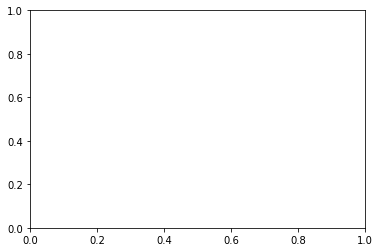

In [113]:
#sns.barplot(x=model_performance_dict.keys(), y="RMSE", data=list_all_models)

fig, ax = plt.subplots()    
#width = 0.75 # the width of the bars 
#ind = np.arange(len(y))  # the x locations for the groups
ax.barv(ind, y, width, color="blue")
#ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('title')
plt.xlabel('x')
plt.ylabel('y')